In [27]:
!pip install ipympl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns
%matplotlib widget


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: C:\Users\Lola Monroy Mir\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [12]:
df = pd.read_csv("archive/Amazon_Unlocked_Mobile.csv")
df

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,1.0
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0.0
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,Very pleased,0.0
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,It works good but it goes slow sometimes but i...,0.0
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,Great phone to replace my lost phone. The only...,0.0
...,...,...,...,...,...,...
413835,Samsung Convoy U640 Phone for Verizon Wireless...,Samsung,79.95,5,another great deal great price,0.0
413836,Samsung Convoy U640 Phone for Verizon Wireless...,Samsung,79.95,3,Ok,0.0
413837,Samsung Convoy U640 Phone for Verizon Wireless...,Samsung,79.95,5,Passes every drop test onto porcelain tile!,0.0
413838,Samsung Convoy U640 Phone for Verizon Wireless...,Samsung,79.95,3,I returned it because it did not meet my needs...,0.0


In [13]:
!pip install ipympl
!pip install transformers
!pip install torch
from transformers import AutoTokenizer, AutoModel
import torch

def get_sentence_embedding(sentence, model, tokenizer):
    # Tokenize input sentence
    tokens = tokenizer(sentence, return_tensors="pt")

    # Get the transformer model output
    with torch.no_grad():
        outputs = model(**tokens)

    # Extract the output embeddings (CLS token)
    embeddings = outputs.last_hidden_state[:, 0, :]

    return embeddings.numpy()

# Load pre-trained model and tokenizer
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# Example sentence
example_sentence = "prajjwal1/tinybert-base"

# Get sentence embedding
sentence_embedding = get_sentence_embedding(example_sentence, model, tokenizer)

# Convert to numpy array for easier handling
sentence_embedding_np = sentence_embedding

print(sentence_embedding_np)



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: C:\Users\Lola Monroy Mir\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: C:\Users\Lola Monroy Mir\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: C:\Users\Lola Monroy Mir\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


[[-3.14555436e-01 -1.29714534e-01 -8.12295228e-02 -1.02534562e-01
   9.84670874e-03  5.87202311e-02  2.14219123e-01  1.81473181e-01
  -3.62781249e-02 -1.68450266e-01 -5.50027303e-02 -1.57682776e-01
  -1.01264760e-01  1.54709503e-01  5.72967008e-02  3.34332615e-01
  -2.03299254e-01  1.42534018e-01  1.73580319e-01 -1.00345779e-02
  -5.52617311e-02 -4.03049171e-01 -1.12609081e-01 -1.87534899e-01
  -9.32236165e-02  1.40794605e-01  1.55620545e-01 -3.79409492e-02
   1.07291274e-01  5.21790013e-02 -2.39131749e-01  1.13351315e-01
  -5.35259247e-02 -1.50900483e-01  2.54728794e-01 -4.45202515e-02
   2.27342807e-02 -2.78615385e-01  1.44556850e-01 -1.68371610e-02
   2.83489004e-03 -1.85280859e-01  1.15627810e-01  4.52037007e-02
  -9.10849944e-02  1.72066942e-01 -2.23935127e+00  2.39019599e-02
  -2.80723453e-01 -1.93219945e-01  5.79183847e-02  6.40439838e-02
   2.32987292e-02  4.93286967e-01  2.98040986e-01  1.88150153e-01
  -6.85828738e-03  1.81621820e-01  3.14592063e-01  7.59335905e-02
  -9.14312

In [22]:
counts = df["Product Name"].value_counts().reset_index()
subset = df[df["Product Name"] == counts.iloc[500]["Product Name"]]
subset["embedding"] = subset["Reviews"].apply(get_sentence_embedding, args = (model, tokenizer))
subset

RuntimeError: The size of tensor a (624) must match the size of tensor b (512) at non-singleton dimension 1

In [29]:

pca = PCA(n_components=3)
embed = np.vstack(subset["embedding"].to_numpy())
project = pca.fit_transform(embed)
kmeans = KMeans(n_clusters=3)
clusters = kmeans.fit_predict(embed)
subset["cluster"] = clusters

/home/hp/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/tmp/ipykernel_19333/2820431430.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset["cluster"] = clusters


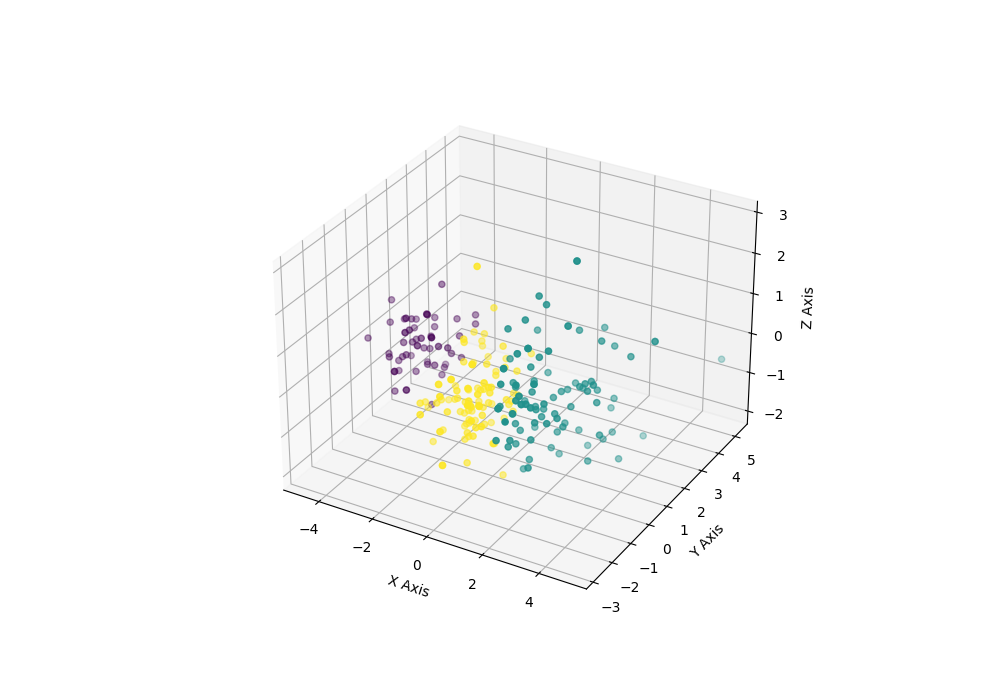

AttributeError: 'PathPatch' object has no attribute 'do_3d_projection'

AttributeError: 'PathPatch' object has no attribute 'do_3d_projection'

In [25]:
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
ax.scatter3D(project[:,0], project[:,1], project[:,2], c=clusters)


/home/hp/.local/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/hp/.local/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/hp/.local/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


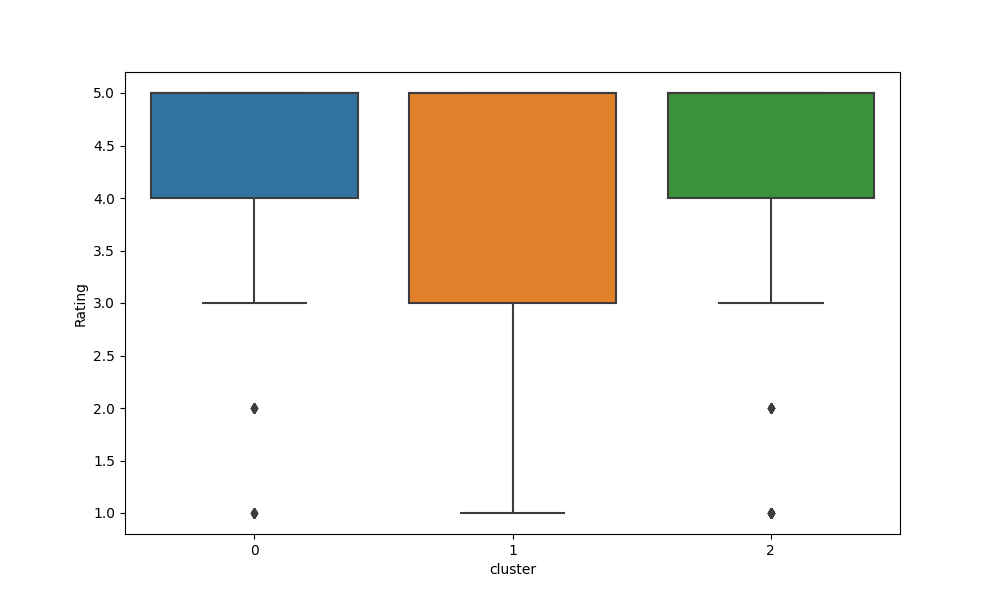

In [34]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='cluster', y='Rating', data=subset)
plt.show()

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Example corpus
corpus = [
    "This is the first document.",
    "This document is the second document.",
    "And this is the third one.",
    "Is this the first document?",
]

# Create the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the corpus
tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)

# Get the feature names (terms) and the TF-IDF scores
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_scores = tfidf_matrix.toarray()

# Create a DataFrame for better visualization (optional)
import pandas as pd
df = pd.DataFrame(tfidf_scores, columns=feature_names)

# Display the results
print(df)


        and  document     first        is       one    second       the  \
0  0.000000  0.469791  0.580286  0.384085  0.000000  0.000000  0.384085   
1  0.000000  0.687624  0.000000  0.281089  0.000000  0.538648  0.281089   
2  0.511849  0.000000  0.000000  0.267104  0.511849  0.000000  0.267104   
3  0.000000  0.469791  0.580286  0.384085  0.000000  0.000000  0.384085   

      third      this  
0  0.000000  0.384085  
1  0.000000  0.281089  
2  0.511849  0.267104  
3  0.000000  0.384085  


In [51]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from collections import Counter
import nltk
nltk.download('stopwords')
nltk.download('punkt')

def preprocess(doc):
    stop_words = set(stopwords.words('english'))
    ps = PorterStemmer()
    processed_docs = []
    words = [ps.stem(word.lower()) for word in word_tokenize(doc) if word.isalpha() and word.lower() not in stop_words]
    return words

def calculate_term_frequency(documents):
    term_frequency = Counter()
    for doc in documents:
        term_frequency.update(doc)
    return term_frequency

subset["preprocessed"] = subset["Reviews"].apply(preprocess)
tf_group = [calculate_term_frequency(subset["preprocessed"][subset["cluster"] == i]) for i in range(3)]
terms_group_more = [{term: tf_group[i][term] for term in tf_group[i] if tf_group[i][term] > tf_group[(i+1)%3][term] 
                        and tf_group[i][term] > tf_group[(i+2)%3][term]} for i in range(3)]

[nltk_data] Downloading package stopwords to /home/hp/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/hp/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/tmp/ipykernel_19333/21858372.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset["preprocessed"] = subset["Reviews"].apply(preprocess)


In [55]:
terms_group_more

{'okay': 1,
 'nonsens': 1,
 'gear': 1,
 'market': 1,
 'shipment': 2,
 'pretti': 2,
 'unkil': 2,
 'kept': 2,
 'thank': 6,
 'coupl': 1,
 'quot': 1,
 'peac': 1,
 'junk': 1,
 'bug': 1,
 'didnt': 1}